# Import Packages

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

from utils_file.tools import load_cache_file, rank_finder
from utils_file.finance_tools import *

warnings.filterwarnings("ignore")

path = "figure_file"

# Load Data

In [2]:
dqn_result = load_cache_file("pre-train-fixWindow/test_result_119.pkl")
dqn_result_reward = list(dqn_result["reward_result"].values())

# Comparison Target: Total S&P500 constituent

# Strategy: Buy and Hold

In [3]:
test_data = pd.read_csv("data_file/test.csv")
tickers = test_data["Ticker"].unique()

In [4]:
# Add daily log return to the original stock price data
BB_value = []

for ticker in tickers:
    temp = test_data[test_data["Ticker"] == ticker]
    temp["ma_line"] = temp["Close"].rolling(window=5).mean()
    std = temp["Close"].rolling(window=5).std()
    temp["upper_bound"] = temp["ma_line"] + std
    temp["lower_bound"] = temp["ma_line"] - std
    temp["log_rtn"] = np.log(temp["Close"] / temp["Close"].shift(1))
    temp = temp.dropna()
    BB_value.append(temp)

test_append = pd.concat(BB_value, ignore_index=True)

In [5]:
# Divide the stock price data of individual stocks according to each month
split_test = {}

unique_years = test_append["Year"].unique()
unique_months = test_append["Month"].unique()

idx = 1
for year in unique_years:
    for month in unique_months:
        split_test[f"state_{idx}"] = {}

        date_mask = (test_append["Year"] == year) & (test_append["Month"] == month)
        mask_table = test_append[date_mask]

        for ticker in tickers:
            split_test[f"state_{idx}"][ticker] = mask_table[
                mask_table["Ticker"] == ticker
            ]

        idx += 1

In [6]:
# 每一支成分股都執行一次 B&H 交易策略
trading_result_BandH = {}

for state in list(split_test.keys()):
    all_ticker_reward = []

    for ticker in tickers:
        all_ticker_reward.append(split_test[state][ticker]["log_rtn"].sum())

    trading_result_BandH[state] = all_ticker_reward

## boxplot for reward

In [7]:
trading_table_BandH = pd.DataFrame(trading_result_BandH)

above_median_x, above_median_y = [], []
below_median_x, below_median_y = [], []

for x, y in enumerate(trading_table_BandH.median()):
    value = dqn_result_reward[x]

    if value > y:
        above_median_x.append(x + 1)
        above_median_y.append(value)

    else:
        below_median_x.append(x + 1)
        below_median_y.append(value)

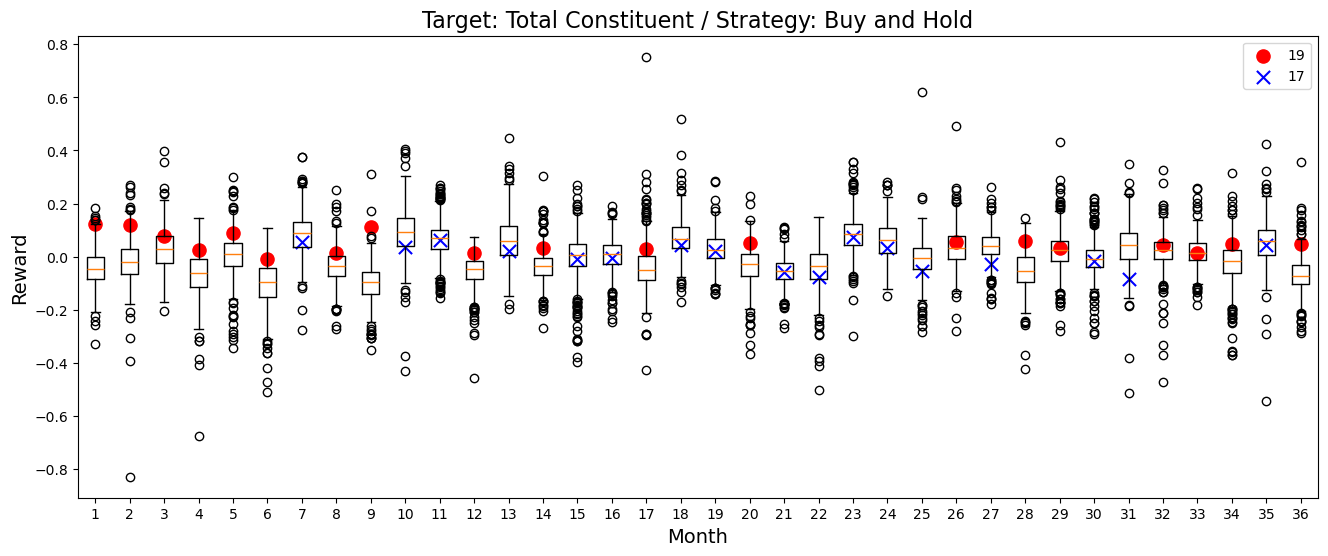

In [8]:
plt.figure(figsize=(16, 6))
plt.boxplot(trading_table_BandH)
plt.scatter(
    above_median_x,
    above_median_y,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x)}",
)
plt.scatter(
    below_median_x,
    below_median_y,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend()
plt.title("Target: Total Constituent / Strategy: Buy and Hold", fontsize=16)
plt.show()

## WRS for target of mean and DQN result

In [9]:
dqn_result_rank = rank_finder(dqn_result_reward, trading_table_BandH)

trading_mean_BandH = trading_table_BandH.mean()
trading_mean_rank_BandH = rank_finder(trading_mean_BandH, trading_table_BandH)

WRS = wilcoxon(dqn_result_rank, trading_mean_rank_BandH, alternative="less")
print(f"p-value of WRS: {WRS[1]: .4f}")

p-value of WRS:  0.0346


[]

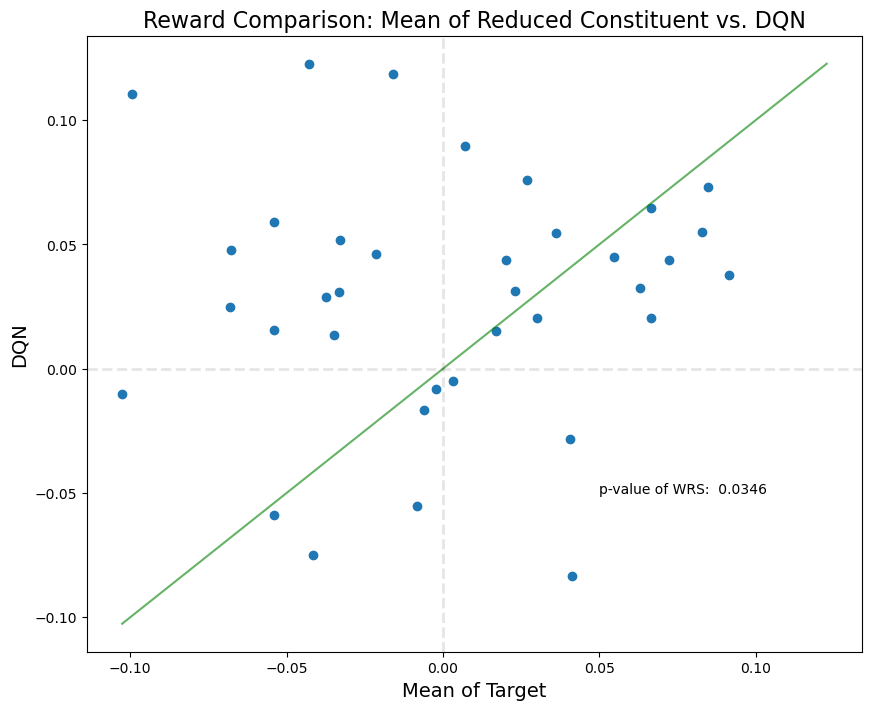

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(trading_mean_BandH, dqn_result_reward)
plt.plot(
    np.linspace(
        min(min(trading_mean_BandH), min(dqn_result_reward)),
        max(max(trading_mean_BandH), max(dqn_result_reward)),
        200,
    ),
    np.linspace(
        min(min(trading_mean_BandH), min(dqn_result_reward)),
        max(max(trading_mean_BandH), max(dqn_result_reward)),
        200,
    ),
    color="green",
    alpha=0.6,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Mean of Target", fontsize=14)
plt.ylabel("DQN", fontsize=14)
plt.title("Reward Comparison: Mean of Reduced Constituent vs. DQN", fontsize=16)
plt.text(0.05, -0.05, f"p-value of WRS: {WRS[1]: .4f}")
plt.plot()

In [11]:
dqn_result_cum_reward = []

for i in range(len(dqn_result_reward)):
    dqn_result_cum_reward.append(sum(dqn_result_reward[: i + 1]))

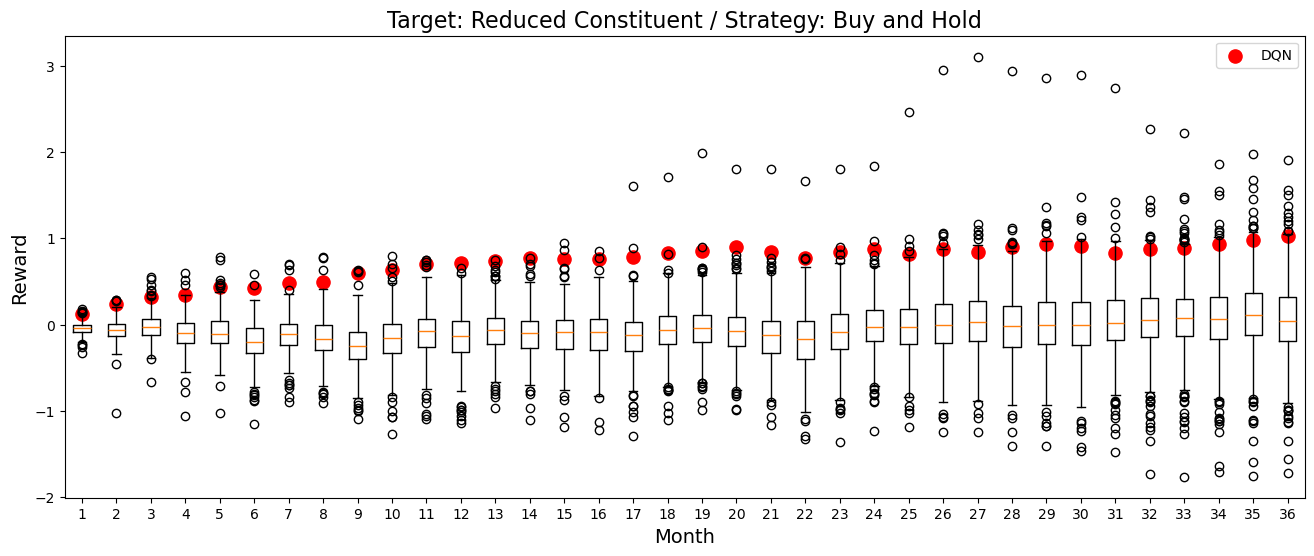

In [12]:
plt.figure(figsize=(16, 6))
plt.boxplot(trading_table_BandH.cumsum(axis=1))
plt.scatter(
    range(1, len(dqn_result_cum_reward) + 1),
    dqn_result_cum_reward,
    s=90,
    color="red",
    marker="o",
    label="DQN",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend()
plt.title("Target: Reduced Constituent / Strategy: Buy and Hold", fontsize=16)
plt.show()